In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Load the dataset 
words = open('names.txt', 'r').read().splitlines()


In [21]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [22]:
# build the dataset
block_size = 3

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        # padded context of zero tokens with block size expected
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(137)
random.shuffle(words)
n1 = int (0.8 * len(words))
n2 = int (0.9 * len(words))
 
Xtr, Ytr = build_dataset(words[:n1])      #80%
Xdev, Ydev = build_dataset(words[n1:n2])  #10%
Xte, Yte = build_dataset(words[n2:])      #10%


torch.Size([182339, 3]) torch.Size([182339])
torch.Size([22895, 3]) torch.Size([22895])
torch.Size([22912, 3]) torch.Size([22912])


In [23]:
# MLP revisited (generalized hyperparameters)

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocab_size = len(itos) # the number of unique character encodings

episilon = 10**-5
g = torch.Generator()
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # kaiming-init for tanh nonlinearity gain/sqrt(fan-in)
# No longer needed since normalization layer will remove this fixed bias
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

#batch propagation parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias ]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True



12097


In [24]:
# MLP Optimization revisited

max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # set up batch X, Y
    
    #forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # represent the vectors with the shape needed by concatenating the dimensions
    hpreact = embcat @ W1 # + b1          # hidden layer pre-activation
    
    # Batch normalization paper insight - make these activations exactly guassian
    # scale and shift
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias # Keep Dim true so that we can broadcast it easily
    
    #scale and shift is now included in step above
    # hpreact = bngain * hpreact + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
     
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < max_steps/2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0 /  200000: 3.2873
  10000 /  200000: 2.0588
  20000 /  200000: 1.9073
  30000 /  200000: 2.2616
  40000 /  200000: 2.1942
  50000 /  200000: 2.0374
  60000 /  200000: 2.6524
  70000 /  200000: 2.2167
  80000 /  200000: 2.0015
  90000 /  200000: 2.3978
 100000 /  200000: 2.5218
 110000 /  200000: 2.3059
 120000 /  200000: 2.0967
 130000 /  200000: 2.4376
 140000 /  200000: 2.0834
 150000 /  200000: 2.3981
 160000 /  200000: 2.0521
 170000 /  200000: 2.1261
 180000 /  200000: 1.8160
 190000 /  200000: 2.1725


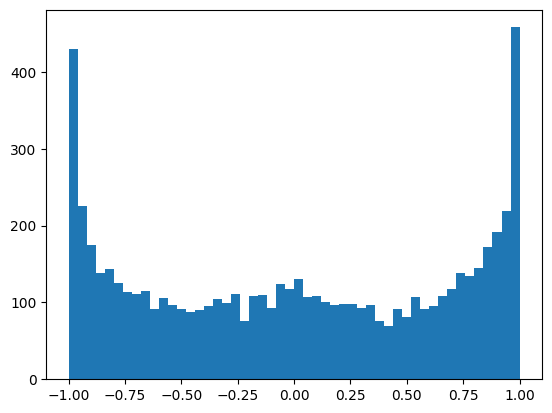

In [25]:
# Let's look at activations of the hidden states and how many of them are maxed out to -1 or 1
# flatten h to single dimension with [-1] and then convert to a python list before plotting it as a hist
plt.hist(h.view(-1).tolist(), 50);

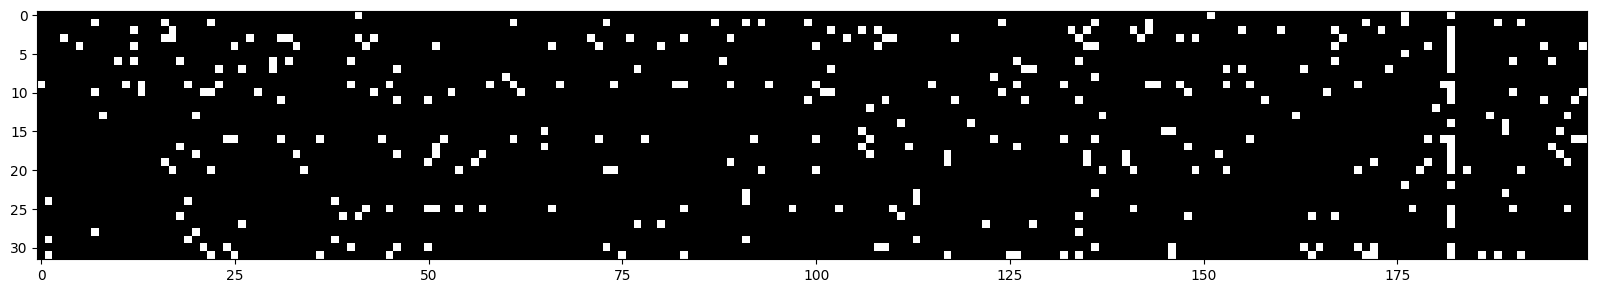

In [26]:

plt.figure(figsize=(20,10))
# Let's also plot a boolean tensor that shows gradients above 0.99 level after taking abs to include both positive and negative values
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

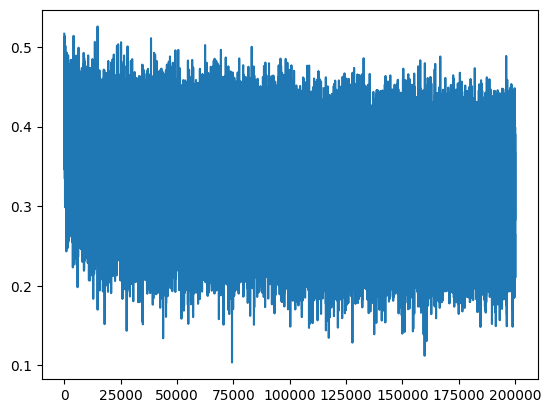

In [27]:

# Plot the loss
plt.plot(lossi)

In [28]:
# Calibrate the batch normalization at the end of the training

with torch.no_grad():
    # pass the training set entirely and get bnmean and bnstd computed
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean & std deviation for the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    
print(f'{bnmean.shape}, {bnstd.shape}')

torch.Size([1, 200]), torch.Size([1, 200])


In [29]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' :  (Xtr, Ytr),
        'val'   :  (Xdev, Ydev),
        'test'  :  (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #contact into ( N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
    # hpreact = (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)# Keep Dim true so that we can broadcast it easily
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0663130283355713
val 2.1250436305999756


In [41]:
#Sample from the model

g = torch.Generator()

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 # + b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

kodolaiyah.
vilyn.
kawiff.
floy.
hel.
ezi.
beon.
jedian.
arviene.
damir.
zette.
tean.
garla.
zicu.
nuvikristonwilvien.
nyloriazniel.
blay.
ami.
davi.
halyn.


In [40]:
emb.shape, embcat.shape, W1.shape, hpreact.shape, h.shape, W2.shape, b2.shape, logits.shape, probs.shape

(torch.Size([1, 3, 10]),
 torch.Size([1, 30]),
 torch.Size([30, 200]),
 torch.Size([1, 200]),
 torch.Size([1, 200]),
 torch.Size([200, 27]),
 torch.Size([27]),
 torch.Size([1, 27]),
 torch.Size([1, 27]))

In [ ]:

# Activation Functions
t = torch.linspace(-10, 10, 10000)



# sigmoid activation function
# 1/(1+e^-x)

sigmoid = 1.0 / (1 + torch.exp(-t))

plt.plot(t,sigmoid); 
plt.grid(visible=True, which='major')

plt.title('sigmoid: 1/(1+e^-x)')

In [ ]:
# Understanding how mean and std deviations of a random guassian distribution is affected when we perform operations

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
w_n = torch.randn(10, 200) / 10**0.5 # sqrt of 10 (fan-in)
y = x @ w
y_n = x @ w_n

print(f'x: mean= {x.mean()}, std={x.std()}')
print(f'y: mean= {y.mean()}, std={y.std()}')
print(f'y_n: mean= {y_n.mean()}, std={y_n.std()}')
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(132)
plt.hist(y.view(-1).tolist(), 50, density=True);
plt.subplot(133)
plt.hist(y_n.view(-1).tolist(), 50, density=True);

# How to preserve the guassian generated so that the standard deviation remains close to 1?
# Sqrt of Fan-in

